## Readmission Dataset: Readmission Prediction
    I will be performing machine learning using the Readmission dataset. Below are some steps that i will follow

- 1 Preparing that data
    - a  Handling of missing data
    - b Encoding of Categorical data
    - c Feature Engineering
- 2 Choosing a model
- 3 Training
- 4 Evaluation
- 5 Prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
from PIL import Image

In [2]:
# Loading Dataset
readmission=pd.read_csv("diabetic_data.csv")

In [3]:
readmission.head(n=3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


In [4]:
#replace '?' with NAN inplace
readmission.replace('?', np.nan,inplace=True)


In [5]:
readmission.head(n=3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


In [6]:
#Count nulls for each column
readmission.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [7]:
#percentage of null values for each column
readmission.isnull().sum()/readmission.count()

encounter_id                 0.000000
patient_nbr                  0.000000
race                         0.022846
gender                       0.000000
age                          0.000000
weight                      30.831717
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                   0.654463
medical_specialty            0.963950
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.000206
diag_2                       0.003530
diag_3                       0.014181
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

30 % of weight column values are nulls, with medical_specialty and payer_code follow suit with 0.96% and 0.65% respectively. I will drop weight column from the dataframe

In [8]:
readmission=readmission.drop(columns='weight')

In [9]:
readmission.dtypes.head(3)

encounter_id     int64
patient_nbr      int64
race            object
dtype: object

In [10]:
#Covert object to categorical dtype
readmission[readmission.select_dtypes('int64').columns]=readmission[readmission.select_dtypes('int64').columns].stack().astype(np.number).unstack()

In [11]:
readmission.dtypes.head(3)

encounter_id    float64
patient_nbr     float64
race             object
dtype: object

# Preparing that data
    a Handling of missing data
    b Encoding of Categorical data
    c Feature Engineering

#### Handling of missing data

In [12]:
#Handling of missing data
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='mean',filler='NA'):
        self.strategy = strategy
        self.fill = filler

    def fit(self, X, y=None):
        if self.strategy in ['mean','median']:
            if not all(X.dtypes == np.number):
               raise ValueError('dtypes mismatch np.number dtype is \
                                 required for '+ self.strategy)
        if self.strategy == 'mean':
            self.fill = X.mean()
        elif self.strategy == 'median':
            self.fill = X.median()
        elif self.strategy == 'mode':
            self.fill = X.mode().iloc[0]
        elif self.strategy == 'fill':
            if type(self.fill) is list and type(X) is pd.DataFrame:
               self.fill = dict([(cname, v) for cname,v in zip(X.columns, self.fill)])
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



In [13]:
#----------------------------------fillna--------------------------------------------------------------------------------
cat_columns=readmission.select_dtypes('object').columns
num_columns=readmission.select_dtypes(exclude='object').columns                        

In [14]:
New_readmission_cat=CustomImputer(strategy='mode').fit_transform(readmission[cat_columns])
New_readmission_num=CustomImputer(strategy='mean').fit_transform(readmission[num_columns])
New_readmission=CustomImputer(strategy='mode').fit_transform(readmission[cat_columns])
New_readmission[num_columns]=CustomImputer(strategy='mean').fit_transform(readmission[num_columns])

In [15]:
New_readmission.head()

,race,gender,age,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,...,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,Caucasian,Female,[0-10),MC,Pediatrics-Endocrinology,250.83,276,250,None,None,...,25.0,1.0,1.0,41.0,0.0,1.0,0.0,0.0,0.0,1.0
1,Caucasian,Female,[10-20),MC,InternalMedicine,276,250.01,255,None,None,...,1.0,7.0,3.0,59.0,0.0,18.0,0.0,0.0,0.0,9.0
2,AfricanAmerican,Female,[20-30),MC,InternalMedicine,648,250,V27,None,None,...,1.0,7.0,2.0,11.0,5.0,13.0,2.0,0.0,1.0,6.0
3,Caucasian,Male,[30-40),MC,InternalMedicine,8,250.43,403,None,None,...,1.0,7.0,2.0,44.0,1.0,16.0,0.0,0.0,0.0,7.0
4,Caucasian,Male,[40-50),MC,InternalMedicine,197,157,250,None,None,...,1.0,7.0,1.0,51.0,0.0,8.0,0.0,0.0,0.0,5.0


#### Encoding of Categorical data

In [16]:
New_readmission_cat.head()

,race,gender,age,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),MC,Pediatrics-Endocrinology,250.83,276,250,None,None,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),MC,InternalMedicine,276,250.01,255,None,None,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),MC,InternalMedicine,648,250,V27,None,None,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),MC,InternalMedicine,8,250.43,403,None,None,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),MC,InternalMedicine,197,157,250,None,None,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [17]:
#Encoding all categorical variable and Target Variable
from sklearn import preprocessing

In [18]:
readmission_cat_col = [s for s in New_readmission_cat.columns if "_id" not in s and "nbr" not in s]
readmission_cat_wo_target=pd.get_dummies(New_readmission_cat[readmission_cat_col].drop(columns='readmitted'))

In [19]:
readmission_cat_wo_target.head()

,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,0,0,1,0,0,1,0,0,1,0,...,1,0,1,0,1,0,0,1,1,0
1,0,0,1,0,0,1,0,0,0,1,...,1,0,1,0,1,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,0,...,1,0,1,0,1,0,0,1,0,1
3,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1
4,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1


In [20]:
New_readmission_num.head()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
0,2278392.0,8222157.0,6.0,25.0,1.0,1.0,41.0,0.0,1.0,0.0,0.0,0.0,1.0
1,149190.0,55629189.0,1.0,1.0,7.0,3.0,59.0,0.0,18.0,0.0,0.0,0.0,9.0
2,64410.0,86047875.0,1.0,1.0,7.0,2.0,11.0,5.0,13.0,2.0,0.0,1.0,6.0
3,500364.0,82442376.0,1.0,1.0,7.0,2.0,44.0,1.0,16.0,0.0,0.0,0.0,7.0
4,16680.0,42519267.0,1.0,1.0,7.0,1.0,51.0,0.0,8.0,0.0,0.0,0.0,5.0


In [21]:
readmission_num_col = [s for s in New_readmission_num.columns if "_id" not in s and "nbr" not in s]
readmission_New=New_readmission_num[readmission_num_col]
readmission_New[readmission_cat_wo_target.columns]=readmission_cat_wo_target

In [22]:
readmission_New.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1.0,41.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,...,1,0,1,0,1,0,0,1,1,0
1,3.0,59.0,0.0,18.0,0.0,0.0,0.0,9.0,0,0,...,1,0,1,0,1,0,1,0,0,1
2,2.0,11.0,5.0,13.0,2.0,0.0,1.0,6.0,1,0,...,1,0,1,0,1,0,0,1,0,1
3,2.0,44.0,1.0,16.0,0.0,0.0,0.0,7.0,0,0,...,1,0,1,0,1,0,1,0,0,1
4,1.0,51.0,0.0,8.0,0.0,0.0,0.0,5.0,0,0,...,1,0,1,0,1,0,1,0,0,1


In [23]:
# Create a target (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(New_readmission_cat['readmitted'])
#list(le.classes_)

readmission_New['readmitted']=pd.DataFrame(le.transform(New_readmission_cat['readmitted']) )

In [24]:
readmission_New.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,race_Asian,...,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,readmitted
0,1.0,41.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,...,0,1,0,1,0,0,1,1,0,2
1,3.0,59.0,0.0,18.0,0.0,0.0,0.0,9.0,0,0,...,0,1,0,1,0,1,0,0,1,1
2,2.0,11.0,5.0,13.0,2.0,0.0,1.0,6.0,1,0,...,0,1,0,1,0,0,1,0,1,2
3,2.0,44.0,1.0,16.0,0.0,0.0,0.0,7.0,0,0,...,0,1,0,1,0,1,0,0,1,2
4,1.0,51.0,0.0,8.0,0.0,0.0,0.0,5.0,0,0,...,0,1,0,1,0,1,0,0,1,2


Now all categorical variables are encoded, new dataframe emerges with 2461 columns. 
I will be applying ML algorithm to the new dataframe as well as dataframe prior to encoding.


   I want see if i can visualise the encoded dataset in 2D, before that i will apply Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) to reduce the 2461 columns to 2D or 3D.
   
   Principal Component Analysis (PCA) applied to this data identifies the combination of attributes that account for the most variance in the data (Somehow like NON-Supervised Learning).
   
   Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes
 (Somehow like Supervised Learning)   
   We'll also normalize the data in some cases.

## Principal Component Analysis (PCA)

In [25]:
import numpy as np
from sklearn.decomposition import PCA
X = readmission_New.drop(columns='readmitted').values
pca = PCA(n_components=5)
pca.fit(X)
X_New=pca.transform(X)
print(pca.explained_variance_ratio_)  
print(pca.singular_values_) 

[0.81809827 0.12994347 0.01353823 0.00726378 0.00526356]
[6331.34694689 2523.31001518  814.46857368  596.58830275  507.84755871]


With the above explained_variance_ratio_ and singular_values_ results, it shows that first two principal components explained over 93% of the 
total variance, I'll be plotting this using scatter plot

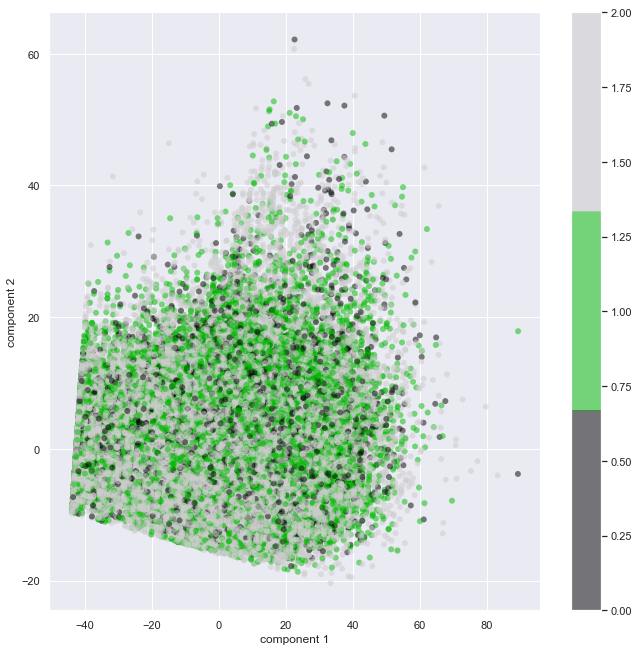

In [26]:
plt.figure(figsize=(11,11))
plt.scatter(X_New[:, 0], X_New[:, 1],
            c=readmission_New.readmitted, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [27]:
# data normalization before PCA
# Create the Scaler object
X_normalized = preprocessing.normalize(X, norm='l2')

In [28]:
pca_X_normalized= PCA(n_components=5)
pca_X_normalized.fit(X_normalized)
X_normalized_New=pca_X_normalized.transform(X_normalized)
print(pca_X_normalized.explained_variance_ratio_)  
print(pca_X_normalized.singular_values_) 

[0.71785865 0.10490272 0.03667534 0.02636978 0.01761346]
[89.849822   34.34718242 20.30882541 17.22070877 14.07408195]


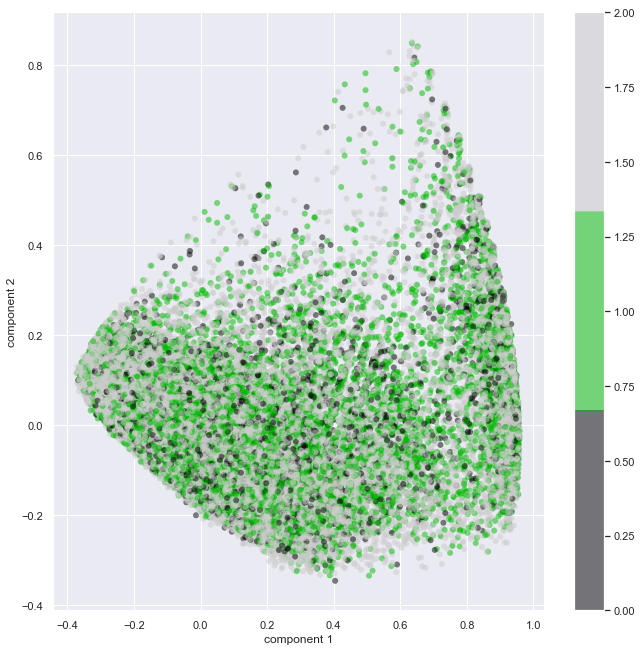

In [29]:
plt.figure(figsize=(11,11))
plt.scatter(X_normalized_New[:, 0], X_normalized_New[:, 1],
            c=readmission_New.readmitted, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 3))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

## Linear Discriminant Analysis (LDA)

In [30]:
 y=readmission_New.readmitted  

<Figure size 792x792 with 0 Axes>

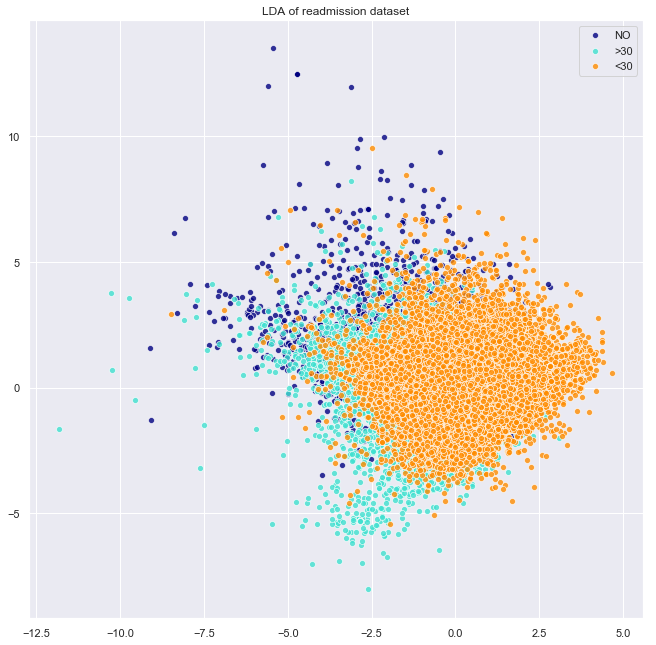

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=None)
lda_X_r11 = lda.fit(X, y).transform(X)

colors = ['navy', 'turquoise', 'darkorange']
lw = 2
target_names=['NO','>30','<30']
plt.figure(figsize=(11,11))
f,axarr=plt.subplots(figsize=(11,11))
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    sns.scatterplot(lda_X_r11[y == i, 0], lda_X_r11[y == i, 1], alpha=.8, color=color,
                label=target_name,ax=axarr)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of readmission dataset')

<Figure size 792x792 with 0 Axes>

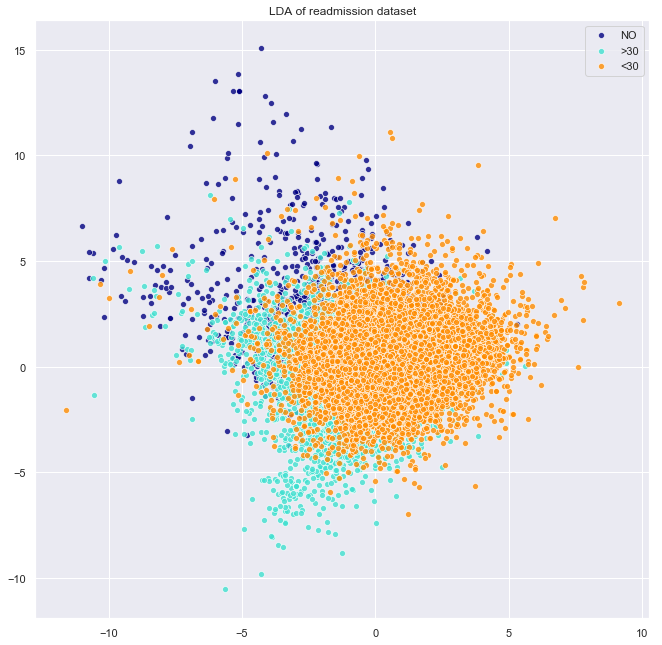

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=None)
lda_X_r1 = lda.fit(X_normalized, y).transform(X_normalized)

colors = ['navy', 'turquoise', 'darkorange']
lw = 2
target_names=['NO','>30','<30']
plt.figure(figsize=(11,11))
f,axarr=plt.subplots(figsize=(11,11))
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    sns.scatterplot(lda_X_r1[y == i, 0], lda_X_r1[y == i, 1], alpha=.8, color=color,
                label=target_name,ax=axarr)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('LDA of readmission dataset')

I will creating new features to see if it can help maximise the seperations between mean of projectd 3 classes of readmission dataset, then i will apply LDA to the newly emerged data and finally visualize the result 

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

### Predictions
i will use 3 different data views from readmission dataframe
1. Normal datafame
2. PCA datafame
3. LDA datafame

#### 1. Normal datafame

In [34]:
# Split our data 
train_normal, test_normal, train_labels_normal, test_labels_normal = train_test_split(X_New,
                                                          readmission_New.readmitted,
                                                          test_size=0.33,
                                                          random_state=42)

#### 2. PCA datafame

In [35]:
# Split our data 
train_pca, test_pca, train_labels_pca, test_labels_pca = train_test_split(X_normalized_New,
                                                          readmission_New.readmitted,
                                                          test_size=0.33,
                                                          random_state=42)

#### 3. LDA datafame

In [36]:
# Split our data
train, test, train_labels, test_labels = train_test_split(lda_X_r1,
                                                          readmission_New.readmitted,
                                                          test_size=0.33,
                                                          random_state=42)

In [38]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


KNeighborsClassifier
****Results****
Accuracy: 48.0690%
Log Loss: 7.638175332314001
LinearDiscriminantAnalysis
****Results****
Accuracy: 57.7346%
Log Loss: 0.8847194207393608
DecisionTreeClassifier
****Results****
Accuracy: 47.3722%
Log Loss: 18.177004258215504
RandomForestClassifier
****Results****
Accuracy: 50.7936%
Log Loss: 3.633618261143826
AdaBoostClassifier
****Results****
Accuracy: 58.2467%
Log Loss: 1.086680782251788
GradientBoostingClassifier
****Results****
Accuracy: 58.3778%
Log Loss: 0.8722095933893326
GaussianNB
****Results****
Accuracy: 55.8497%
Log Loss: 0.9859813992060746
SVC
****Results****
Accuracy: 58.0085%
Log Loss: 0.9038296627790395
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 56.3351%
Log Loss: 0.9613240073802203


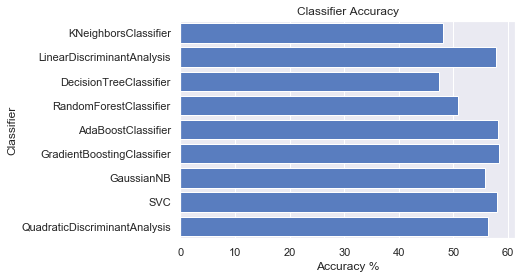

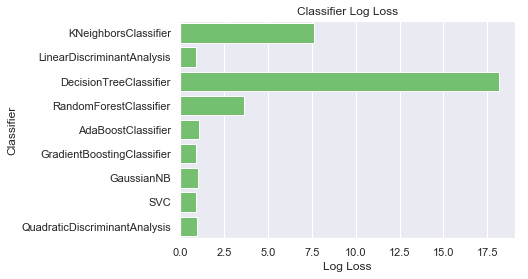

In [39]:
#1
X_train=train
X_test=test
y_train=train_labels
y_test=test_labels 

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    SVC(kernel="rbf", C=0.025, probability=True),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

KNeighborsClassifier
****Results****
Accuracy: 44.1473%
Log Loss: 8.194416345458082
LinearDiscriminantAnalysis
****Results****
Accuracy: 53.7564%
Log Loss: 0.9434119323661873
DecisionTreeClassifier
****Results****
Accuracy: 43.9717%
Log Loss: 19.351505721544807
RandomForestClassifier
****Results****
Accuracy: 49.2005%
Log Loss: 2.5644909616270617
AdaBoostClassifier
****Results****
Accuracy: 54.8492%
Log Loss: 1.0908856514563765
GradientBoostingClassifier
****Results****
Accuracy: 55.2720%
Log Loss: 0.9250828263672982
GaussianNB
****Results****
Accuracy: 53.3722%
Log Loss: 0.955503859750788
SVC
****Results****
Accuracy: 53.8278%
Log Loss: 0.9464538206730014
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 53.4824%
Log Loss: 0.9644835228037231


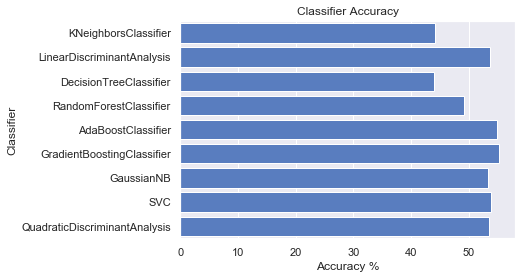

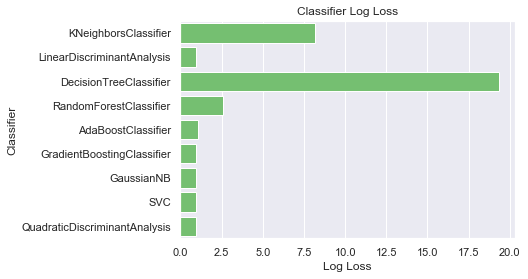

In [40]:
#2
#train_pca, train_labels_pca
X_train=train_pca
X_test=test_pca
y_train=train_labels_pca
y_test=test_labels_pca 

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    SVC(kernel="rbf", C=0.025, probability=True),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

KNeighborsClassifier
****Results****
Accuracy: 44.4243%
Log Loss: 8.08527449887971
LinearDiscriminantAnalysis
****Results****
Accuracy: 54.7569%
Log Loss: 0.9364058978179011
DecisionTreeClassifier
****Results****
Accuracy: 44.2932%
Log Loss: 19.24043202799002
RandomForestClassifier
****Results****
Accuracy: 49.4506%
Log Loss: 2.6316627942795363
AdaBoostClassifier
****Results****
Accuracy: 55.3405%
Log Loss: 1.0906685690359028
GradientBoostingClassifier
****Results****
Accuracy: 55.8020%
Log Loss: 0.9197676337794918
GaussianNB
****Results****
Accuracy: 54.1494%
Log Loss: 0.9307543280818535
SVC
****Results****
Accuracy: 53.8278%
Log Loss: 0.9425484601935293
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 54.1911%
Log Loss: 0.9336133371602433


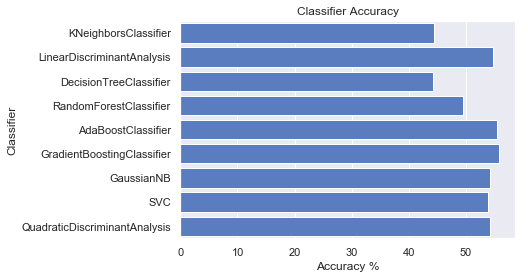

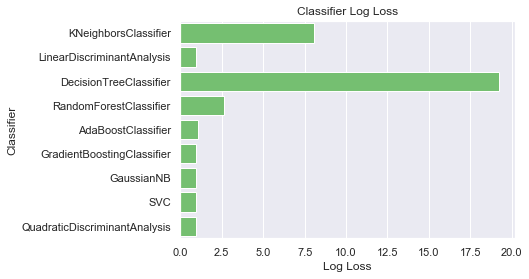

In [41]:
#3
#train_normal, test_normal, train_labels_normal, test_labels_normal 
X_train=train_normal
X_test=test_normal
y_train=train_labels_normal
y_test=test_labels_normal 

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    SVC(kernel="rbf", C=0.025, probability=True),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
print("="*30)

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()